In [1]:
cd /home/ubuntu/FedEM/

/home/ubuntu/FedEM


In [2]:
# Import General Libraries
import os
import argparse
import torch
import copy
import pickle
import random
import numpy as np
import pandas as pd

# Import FedEM based Libraries
from utils.utils import *
from utils.constants import *
from utils.args import *
from torch.utils.tensorboard import SummaryWriter
from run_experiment import *
from models import *

# Import Transfer Attack
from transfer_attacks.Personalized_NN import *
from transfer_attacks.Params import *
from transfer_attacks.Transferer import *
from transfer_attacks.Args import *

from transfer_attacks.TA_utils import *
from transfer_attacks.Boundary_Transferer import *

In [3]:
# Manually set argument parameters
args_ = Args()
args_.experiment = "cifar10"
args_.method = "FedEM_adv"
args_.decentralized = False
args_.sampling_rate = 1.0
args_.input_dimension = None
args_.output_dimension = None
args_.n_learners= 3
args_.n_rounds = 10
args_.bz = 128
args_.local_steps = 1
args_.lr_lambda = 0
args_.lr =0.03
args_.lr_scheduler = 'multi_step'
args_.log_freq = 10
args_.device = 'cuda'
args_.optimizer = 'sgd'
args_.mu = 0
args_.communication_probability = 0.1
args_.q = 1
args_.locally_tune_clients = False
args_.seed = 1234
args_.verbose = 1
args_.save_path = 'weights/cifar/22_01_09_fedavg_n80_benign/'
args_.validation = False
args_.num_user = 40

# Generate the dummy values here
aggregator, clients = dummy_aggregator(args_, num_user=args_.num_user)

==> Clients initialization..
===> Building data iterators..


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 80/80 [00:00<00:00, 267.59it/s]


===> Initializing clients..


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 80/80 [00:53<00:00,  1.50it/s]


==> Test Clients initialization..
===> Building data iterators..


0it [00:00, ?it/s]


===> Initializing clients..


0it [00:00, ?it/s]


++++++++++++++++++++++++++++++
Global..
Train Loss: 2.292 | Train Acc: 12.195% |Test Loss: 2.292 | Test Acc: 12.291% |
++++++++++++++++++++++++++++++++++++++++++++++++++
################################################################################


In [4]:
# Combine Validation Data across all clients as test
data_x = []
data_y = []

for i in range(len(clients)):
    daniloader = clients[i].val_iterator
    for (x,y,idx) in daniloader.dataset:
        data_x.append(x)
        data_y.append(y)

data_x = torch.stack(data_x)
data_y = torch.stack(data_y)

# Create dataloader from validation dataset that allows for diverse batch size
dataloader = Custom_Dataloader(data_x, data_y)

In [9]:
exp_names = ['weights/neurips/cifar/client_count/fedem_adv_new2/c5/',
             'weights/neurips/cifar/client_count/fedem_adv_new2/c10/',
             'weights/neurips/cifar/client_count/fedem_adv_new2/c20/',
             'weights/neurips/cifar/client_count/fedem_adv_new2/c30/',
             'weights/neurips/cifar/client_count/fedem_adv_new2/c40/']

exp_names = ['weights/neurips/cifar/client_count/fedavg_adv_new2/c5/',
             'weights/neurips/cifar/client_count/fedavg_adv_new2/c10/',
             'weights/neurips/cifar/client_count/fedavg_adv_new2/c20/',
             'weights/neurips/cifar/client_count/fedavg_adv_new2/c30/',
             'weights/neurips/cifar/client_count/fedavg_adv_new2/c40/']


train_item = 'train_client_weights.npy'

cc = [5,10,20,30,40]
# cc = [50]

In [39]:
# Inter Boundary Distance Metric
custom_batch_size = 500

exp_logs = {}
num_exp = len(exp_names)

for j in range(num_exp):
    
    aggregator, clients = dummy_aggregator(args_, num_user=cc[j])
    num_victims = cc[j]
    
    # Set Up Dictionaries -- list holds the adversary idx


    logs_adv = []

    for i in range(num_victims):
        adv_dict = {}
        adv_dict['orig_acc_transfers'] = None
        adv_dict['orig_similarities'] = None
        adv_dict['adv_acc_transfers'] = None
        adv_dict['adv_similarities_target'] = None
        adv_dict['adv_similarities_untarget'] = None
        adv_dict['adv_target'] = None
        adv_dict['adv_miss'] = None
        adv_dict['metric_alignment'] = None
        adv_dict['ib_distance_legit'] = None
        adv_dict['ib_distance_adv'] = None

        logs_adv += [adv_dict]

    exp_logs[j] = copy.deepcopy(logs_adv)

    
    
    print('processing file', exp_names[j], '...')
    
    # Change name if need be
    args_.save_path = exp_names[j]

    # Import weights for aggregator
    aggregator.load_state(args_.save_path)

    # This is where the models are stored -- one for each mixture --> learner.model for nn
    hypotheses = aggregator.global_learners_ensemble.learners

    # obtain the state dict for each of the weights 
    weights_h = []

    for h in hypotheses:
        weights_h += [h.model.state_dict()]
        
    weight_name = args_.save_path + train_item
    weights = np.load(weight_name)
    np.set_printoptions(formatter={'float': lambda x: "{0:0.2f}".format(x)})

    # Set model weights
    model_weights = []
    num_models = num_victims

    for i in range(num_models):
        model_weights += [weights[i]]


    # Generate the weights to test on as linear combinations of the model_weights
    models_test = []

    for (w0,w1,w2) in model_weights:
        # first make the model with empty weights
        new_model = copy.deepcopy(hypotheses[0].model)
        new_model.eval()
        new_weight_dict = copy.deepcopy(weights_h[0])
        for key in weights_h[0]:
            new_weight_dict[key] = w0*weights_h[0][key]  + w1*weights_h[1][key] +w2*weights_h[2][key] 
        new_model.load_state_dict(new_weight_dict)
        models_test += [new_model]
    

    victim_idxs = range(num_victims)

    for adv_idx in victim_idxs:
        print("\t Adv idx:", adv_idx)
        # Perform Attacks
        dataloader = load_client_data(clients = clients, c_id = adv_idx, mode = 'test') # or test/train
        batch_size = min(custom_batch_size, dataloader.y_data.shape[0])
        
        t1 = Transferer(models_list=models_test, dataloader=dataloader)
        t1.generate_victims(victim_idxs)
        
        t1.atk_params = PGD_Params()
        t1.atk_params.set_params(batch_size=batch_size, iteration = 10,
                       target = 3, x_val_min = torch.min(data_x), x_val_max = torch.max(data_x),
                       step_size = 0.01, step_norm = "inf", eps = 4, eps_norm = 2)

        t1.generate_advNN(adv_idx)
        t1.generate_xadv(atk_type = "pgd")
        t1.send_to_victims(victim_idxs)
        # t1.check_empirical_metrics(orig_flag = True)

        # Log Performance
        exp_logs[j][adv_idx]['orig_acc_transfers'] = copy.deepcopy(t1.orig_acc_transfers)
        exp_logs[j][adv_idx]['orig_similarities'] = copy.deepcopy(t1.orig_similarities)
        exp_logs[j][adv_idx]['adv_acc_transfers'] = copy.deepcopy(t1.adv_acc_transfers)
        exp_logs[j][adv_idx]['adv_similarities_target'] = copy.deepcopy(t1.adv_similarities)        
        exp_logs[j][adv_idx]['adv_target'] = copy.deepcopy(t1.adv_target_hit)

        # Miss attack
        t1.atk_params.set_params(batch_size=batch_size, iteration = 10,
                       target = -1, x_val_min = torch.min(data_x), x_val_max = torch.max(data_x),
                       step_size = 0.01, step_norm = "inf", eps = 4, eps_norm = 2)
        t1.generate_xadv(atk_type = "pgd")
        t1.send_to_victims(victim_idxs)
        exp_logs[j][adv_idx]['adv_miss'] = copy.deepcopy(t1.adv_acc_transfers)
        exp_logs[j][adv_idx]['adv_similarities_untarget'] = copy.deepcopy(t1.adv_similarities)


    del models_test

==> Clients initialization..
===> Building data iterators..


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 80/80 [00:00<00:00, 343.84it/s]


===> Initializing clients..


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 80/80 [00:50<00:00,  1.57it/s]


==> Test Clients initialization..
===> Building data iterators..


0it [00:00, ?it/s]


===> Initializing clients..


0it [00:00, ?it/s]


++++++++++++++++++++++++++++++
Global..
Train Loss: 2.291 | Train Acc: 12.179% |Test Loss: 2.298 | Test Acc: 10.600% |
++++++++++++++++++++++++++++++++++++++++++++++++++
################################################################################
processing file weights/neurips/cifar/client_count/fedavg_adv_new2/c5/ ...
	 Adv idx: 0
	 Adv idx: 1
	 Adv idx: 2
	 Adv idx: 3
	 Adv idx: 4
==> Clients initialization..
===> Building data iterators..


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 80/80 [00:00<00:00, 339.36it/s]


===> Initializing clients..


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 80/80 [00:51<00:00,  1.56it/s]


==> Test Clients initialization..
===> Building data iterators..


0it [00:00, ?it/s]


===> Initializing clients..


0it [00:00, ?it/s]


++++++++++++++++++++++++++++++
Global..
Train Loss: 2.293 | Train Acc: 12.581% |Test Loss: 2.296 | Test Acc: 11.812% |
++++++++++++++++++++++++++++++++++++++++++++++++++
################################################################################
processing file weights/neurips/cifar/client_count/fedavg_adv_new2/c10/ ...
	 Adv idx: 0
	 Adv idx: 1
	 Adv idx: 2
	 Adv idx: 3
	 Adv idx: 4
	 Adv idx: 5
	 Adv idx: 6
	 Adv idx: 7
	 Adv idx: 8
	 Adv idx: 9
==> Clients initialization..
===> Building data iterators..


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 80/80 [00:00<00:00, 347.36it/s]


===> Initializing clients..


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 80/80 [00:51<00:00,  1.54it/s]


==> Test Clients initialization..
===> Building data iterators..


0it [00:00, ?it/s]


===> Initializing clients..


0it [00:00, ?it/s]


++++++++++++++++++++++++++++++
Global..
Train Loss: 2.292 | Train Acc: 12.302% |Test Loss: 2.293 | Test Acc: 12.782% |
++++++++++++++++++++++++++++++++++++++++++++++++++
################################################################################
processing file weights/neurips/cifar/client_count/fedavg_adv_new2/c20/ ...
	 Adv idx: 0
	 Adv idx: 1
	 Adv idx: 2
	 Adv idx: 3
	 Adv idx: 4
	 Adv idx: 5
	 Adv idx: 6
	 Adv idx: 7
	 Adv idx: 8
	 Adv idx: 9
	 Adv idx: 10
	 Adv idx: 11
	 Adv idx: 12
	 Adv idx: 13
	 Adv idx: 14
	 Adv idx: 15
	 Adv idx: 16
	 Adv idx: 17
	 Adv idx: 18
	 Adv idx: 19
==> Clients initialization..
===> Building data iterators..


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 80/80 [00:00<00:00, 340.73it/s]


===> Initializing clients..


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 80/80 [00:51<00:00,  1.56it/s]


==> Test Clients initialization..
===> Building data iterators..


0it [00:00, ?it/s]


===> Initializing clients..


0it [00:00, ?it/s]


++++++++++++++++++++++++++++++
Global..
Train Loss: 2.292 | Train Acc: 12.212% |Test Loss: 2.292 | Test Acc: 12.377% |
++++++++++++++++++++++++++++++++++++++++++++++++++
################################################################################
processing file weights/neurips/cifar/client_count/fedavg_adv_new2/c30/ ...
	 Adv idx: 0
	 Adv idx: 1
	 Adv idx: 2
	 Adv idx: 3
	 Adv idx: 4
	 Adv idx: 5
	 Adv idx: 6
	 Adv idx: 7
	 Adv idx: 8
	 Adv idx: 9
	 Adv idx: 10
	 Adv idx: 11
	 Adv idx: 12
	 Adv idx: 13
	 Adv idx: 14
	 Adv idx: 15
	 Adv idx: 16
	 Adv idx: 17
	 Adv idx: 18
	 Adv idx: 19
	 Adv idx: 20
	 Adv idx: 21
	 Adv idx: 22
	 Adv idx: 23
	 Adv idx: 24
	 Adv idx: 25
	 Adv idx: 26
	 Adv idx: 27
	 Adv idx: 28
	 Adv idx: 29
==> Clients initialization..
===> Building data iterators..


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 80/80 [00:00<00:00, 337.64it/s]


===> Initializing clients..


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 80/80 [00:51<00:00,  1.54it/s]


==> Test Clients initialization..
===> Building data iterators..


0it [00:00, ?it/s]


===> Initializing clients..


0it [00:00, ?it/s]


++++++++++++++++++++++++++++++
Global..
Train Loss: 2.292 | Train Acc: 12.195% |Test Loss: 2.292 | Test Acc: 12.291% |
++++++++++++++++++++++++++++++++++++++++++++++++++
################################################################################
processing file weights/neurips/cifar/client_count/fedavg_adv_new2/c40/ ...
	 Adv idx: 0
	 Adv idx: 1
	 Adv idx: 2
	 Adv idx: 3
	 Adv idx: 4
	 Adv idx: 5
	 Adv idx: 6
	 Adv idx: 7
	 Adv idx: 8
	 Adv idx: 9
	 Adv idx: 10
	 Adv idx: 11
	 Adv idx: 12
	 Adv idx: 13
	 Adv idx: 14
	 Adv idx: 15
	 Adv idx: 16
	 Adv idx: 17
	 Adv idx: 18
	 Adv idx: 19
	 Adv idx: 20
	 Adv idx: 21
	 Adv idx: 22
	 Adv idx: 23
	 Adv idx: 24
	 Adv idx: 25
	 Adv idx: 26
	 Adv idx: 27
	 Adv idx: 28
	 Adv idx: 29
	 Adv idx: 30
	 Adv idx: 31
	 Adv idx: 32
	 Adv idx: 33
	 Adv idx: 34
	 Adv idx: 35
	 Adv idx: 36
	 Adv idx: 37
	 Adv idx: 38
	 Adv idx: 39


Organizing and plotting data

In [40]:
metrics = ['orig_acc_transfers','orig_similarities','adv_acc_transfers','adv_similarities_target',
           'adv_similarities_untarget','adv_target','adv_miss'] #,'metric_alignment']


orig_acc = []
orig_sim = []
adv_acc = []
adv_sim_target = []
adv_sim_untarget = []
adv_target = []
adv_miss = []

for i in range(len(exp_names)):
    victim_idxs = range(cc[i])
    
    orig_acc += [np.zeros([len(victim_idxs),len(victim_idxs)])]
    orig_sim += [np.zeros([len(victim_idxs),len(victim_idxs)])]
    adv_acc += [np.zeros([len(victim_idxs),len(victim_idxs)]) ]
    adv_sim_target += [np.zeros([len(victim_idxs),len(victim_idxs)]) ]
    adv_sim_untarget += [np.zeros([len(victim_idxs),len(victim_idxs)]) ]
    adv_target += [np.zeros([len(victim_idxs),len(victim_idxs)])]
    adv_miss += [np.zeros([len(victim_idxs),len(victim_idxs)]) ]
    
    for adv_idx in range(len(victim_idxs)):
        for victim in range(len(victim_idxs)):
            orig_acc[i][adv_idx,victim] = exp_logs[i][victim_idxs[adv_idx]][metrics[0]][victim_idxs[victim]].data.tolist()
            orig_sim[i][adv_idx,victim] = exp_logs[i][victim_idxs[adv_idx]][metrics[1]][victim_idxs[victim]].data.tolist()
            adv_acc[i][adv_idx,victim] = exp_logs[i][victim_idxs[adv_idx]][metrics[2]][victim_idxs[victim]].data.tolist()
            adv_sim_target[i][adv_idx,victim] = exp_logs[i][victim_idxs[adv_idx]][metrics[3]][victim_idxs[victim]].data.tolist()
            adv_sim_untarget[i][adv_idx,victim] = exp_logs[i][victim_idxs[adv_idx]][metrics[4]][victim_idxs[victim]].data.tolist()
            adv_target[i][adv_idx,victim] = exp_logs[i][victim_idxs[adv_idx]][metrics[5]][victim_idxs[victim]].data.tolist()
            adv_miss[i][adv_idx,victim] = exp_logs[i][victim_idxs[adv_idx]][metrics[6]][victim_idxs[victim]].data.tolist()

In [41]:
# Edit desired data
x = [5,10,20,30,40]
# Acc
y_acc = []
y_robust = []
y_target = []

y_acc_std = []
y_robust_std = []
y_target_std = []

for i in range(len(exp_names)):
    y_acc += [np.mean(np.diagonal(orig_acc[i]))]
    y_robust += [avg_nondiag(adv_miss[i])]
    y_target += [avg_nondiag(adv_target[i])]
    
    y_acc_std += [np.std(orig_acc[i])]
    y_robust_std += [np.std(adv_miss[i])]
    y_target_std += [np.std(adv_target[i])]
    
print('y_acc', y_acc)
print('y_robust', y_robust)
print('y_target', y_target)

print('y_acc_std', y_acc_std)
print('y_robust_std', y_robust_std)
print('y_target_std', y_target_std)


y = [y_acc, y_robust, y_target]
y_std = [y_acc_std, y_robust_std, y_target_std]

y_acc [0.5988121032714844, 0.6549030929803848, 0.6640259385108948, 0.7174073308706284, 0.7237591832876206]
y_robust [0.08143896963447332, 0.13016922809183598, 0.11168823037296534, 0.1819001279771328, 0.1540095795877278]
y_target [0.5355743408203125, 0.45576061606407164, 0.6043416723608971, 0.47870915234088895, 0.5019599623978138]
y_acc_std [0.051548224315597115, 0.08284481196275756, 0.09497676847760395, 0.08358564853912842, 0.05610342353236544]
y_robust_std [0.041481656808715184, 0.04624359431136321, 0.04705732433332128, 0.057708528924531995, 0.05114366122031799]
y_target_std [0.06318155411997745, 0.047490241580680916, 0.08415200847693345, 0.09548097144816088, 0.09577778891143914]


Text(0.5, 1.0, 'CIFAR-10 Federated Client Count')

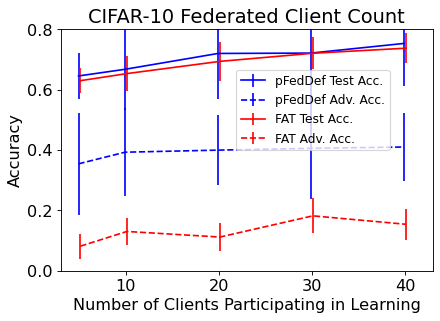

In [42]:
# FedEM - old 0.03 lr
y_acc_em = [0.6450916767120362, 0.667163860797882, 0.7196145206689835, 0.720850157737732, 0.7528059154748916]
y_robust_em = [0.3376933032646775, 0.3707165161354674, 0.3706623485507934, 0.367587899275381, 0.3754598111081391]
y_target_em = [0.16837104493752122, 0.2121713483085235, 0.2247929244939434, 0.22865982262374854, 0.23709892451357192]

# y_acc_em = [0.5819306254386902, 0.6657283306121826, 0.7431143581867218, 0.7719452460606893, 0.7966105282306671]
y_robust_em =  [0.35415015784092246, 0.39264643508940933, 0.3994966171436796, 0.4055137311729292, 0.40981366842006073]
y_target_em =  [0.13879860425367951, 0.20127729040880998, 0.22036700596248632, 0.21891754053789994, 0.22881760303444493]

y_acc_em_std = [0.07715692702770657, 0.134821769318538, 0.14979020426055112, 0.1725262015915895, 0.13955413658865676]
y_robust_em_std = [0.16842491698974255, 0.14584983949968125, 0.11692460946142592, 0.168527260968774, 0.11356905465607631]
y_target_em_std = [0.22282912442323527, 0.15064613492510565, 0.1524870111640661, 0.17622101766056286, 0.13216387077689332]

# FedAvg - 0.03 lr 
y_acc_av = [0.6294841051101685, 0.6529397249221802, 0.6934066414833069, 0.7202447414398193, 0.7370424076914788]
y_robust_av = [0.015053732320666313, 0.029244875721633434, 0.030035770777612925, 0.042258040669063725, 0.051227377727627754]
y_target_av = [0.7822269797325134, 0.7007585525512695, 0.677129927277565, 0.6396990636984508, 0.6634831979870797]

# y_acc [0.6941302180290222, 0.6607008337974548, 0.7449679762125015, 0.7697312970956166, 0.7814813435077668]
y_robust_av =  [0.08143896963447332, 0.13016922809183598, 0.11168823037296534, 0.1819001279771328, 0.1540095795877278]
# y_target [0.6277596950531006, 0.6878000915050506, 0.6856336414813995, 0.6380018383264542, 0.6570352114737034]

y_acc_av_std = [0.04031361514283589, 0.05854536878793412, 0.06402912990515197, 0.05242600881256371, 0.04878897240792139]
y_robust_av_std = [0.01101476494045161, 0.017256414589478505, 0.015363092648985437, 0.0250374195485548, 0.027936583203989007]
y_target_av_std = [0.03636901079467588, 0.025679957085663212, 0.06059209049248106, 0.0843089274817277, 0.08538553261566446]

y1 = [y_acc_em, y_robust_em, y_target_em]
y1_std = [y_acc_em_std, y_robust_em_std, y_target_em_std]
y2 = [y_acc_av, np.multiply(y_robust_av,1), y_target_av]
y2_std = [y_acc_av_std, np.multiply(y_robust_std,1), y_target_av_std]


font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 14.5}

plt.rc('font', **font)


names1 = ['pFedDef Test Acc.', 'pFedDef Adv. Acc.']
names2 = ['FAT Test Acc.', 'FAT Adv. Acc.']
colors = ['b','r']
types = ['-', '--']

plt.figure(figsize=(6, 4), dpi=80)
offset = 0.1


for i in range(len(names1)):
    plt.errorbar(np.array(x) - offset,y1[i], y1_std[i], label= names1[i], linestyle = types[i], color = colors[0])
for i in range(len(names2)):
    plt.errorbar(np.array(x) + offset ,y2[i], y2_std[i], label= names2[i], linestyle = types[i], color = colors[1])
    
plt.legend(frameon=True,loc = (0.47, 0.50), prop={'size': 11})
plt.xlim(3, 43);
plt.ylim(0.0, 0.8);
plt.xlabel('Number of Clients Participating in Learning')
plt.ylabel('Accuracy')
plt.title("CIFAR-10 Federated Client Count")

